In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm import tqdm

In [33]:
# Data agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"

Make CNN for MNIST handwritten digit recognition

In [45]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10

In [47]:
# Load the MNIST dataset
trainDataset = datasets.MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)
testDataset = datasets.MNIST(root='data/', train=False, transform=transforms.ToTensor())

# Create data loaders
trainLoader = torch.utils.data.DataLoader(dataset=trainDataset, batch_size=batch_size, shuffle=True)
testLoader = torch.utils.data.DataLoader(dataset=testDataset, batch_size=batch_size, shuffle=False)


torch.Size([28, 28])

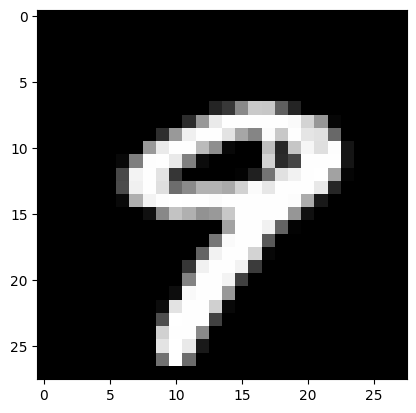

In [87]:
randInd = torch.randint(0,10,(1,))
image, label = testDataset[randInd.item()]
plt.imshow(image.squeeze(), cmap='gray')

image.squeeze().shape

CNN Model

In [35]:
class LeNet(nn.Module):
    def __init__(self, channels, classes):
        super(LeNet,self).__init__()
        
        # LeNet Architecture
        
        # First Block
        self.convBlock1 = nn.Conv2d(channels, 20, (5,5))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d((2,2), (2,2))

        # Second Block
        self.convBlock2 = nn.Conv2d(20,50, (5,5))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d((2,2), (2,2))

        # Fully Connected Layer
        self.fullyConnected1 = nn.Linear(800,500)
        self.relu3 = nn.ReLU()

        # Softmax for logit to predictions
        self.fullyConnected2 = nn.Linear(500,classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self,x):

        # First Block Pass
        x = self.maxpool1(self.relu1(self.convBlock1(x)))
        
        # Second Block Pass
        x = self.maxpool2(self.relu2(self.convBlock2(x)))
        
        # Flatten and pass to Fully Connected Layer
        x = self.relu3(self.fullyConnected1(torch.flatten(x,1)))

        # Softmax Pass
        x = self.fullyConnected2(x)
        output = self.logSoftmax(x)

        return output


Train Init

In [ ]:
# HYPERPARAMETERS
lr = 1e-3
lr = 1e-6
# lr = 0.01
BATCH_SIZE = 32
epochs = 100

# Split data
trainSplit = 0.8
valSplit = 1-trainSplit

trainSamples = int(len(trainDataset) * trainSplit)
valSamples = int(round(len(trainDataset) * valSplit,0))

(trainData, valData) = random_split(trainDataset, [trainSamples, valSamples], generator=torch.Generator().manual_seed(42))

In [ ]:
# Loaders
trainLoader = torch.utils.data.DataLoader(trainData, shuffle=True, batch_size=BATCH_SIZE)
valLoader = torch.utils.data.DataLoader(valData, batch_size=BATCH_SIZE)
testLoader = torch.utils.data.DataLoader(testDataset, batch_size=BATCH_SIZE)


# Batches
trainBatches = len(trainLoader.dataset) // BATCH_SIZE
valBatches = len(valLoader.dataset) // BATCH_SIZE

In [ ]:
# Init

model = LeNet(1,len(trainData.dataset.classes)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
lossFn = nn.NLLLoss()

modelRes = {
    "train_loss" : [],
    "train_acc" : [],
    "val_loss" : [],
    "val_acc" : []
}

# Timing
startTime = time.time()

Training and Testing Loop

In [ ]:
# Training Loop

for epoch in tqdm(range(epochs), desc="Training Epochs"):
    
    model.train()

     # Create inner tqdm progress bar for batches
    train_batch_progress = tqdm(trainLoader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

    totalTrainLoss = 0
    totalValLoss = 0

    trainCorrect = 0
    valCorrect = 0


    # Forward Pass
    for (x,y) in train_batch_progress:
        (x,y) = (x.to(device),y.to(device))

        # Loss
        pred = model(x)
        loss = lossFn(pred, y)
    
        # Optimizer Zero Grad
        optimizer.zero_grad()
    
        # Loss Backward
        loss.backward()

        # Optimizer Step 
        optimizer.step()

        totalTrainLoss += loss.item()
        totalTrainLoss = loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item() 
    
    model.eval()
    with torch.inference_mode():
        for (xVal, yVal) in valLoader:
            (xVal, yVal) = (xVal.to(device), yVal.to(device))

            # Forward Pass
            valPred = model(xVal)

            # Loss
            valLoss = lossFn(valPred, yVal)
            totalValLoss += valLoss.item()
            totalValLoss = valLoss

            valCorrect += (valPred.argmax(1) == yVal).type(torch.float).sum().item() 

    print(f'Train Loss: {totalTrainLoss} | Val Loss: {totalValLoss} | Val Correct: {valCorrect}')

        



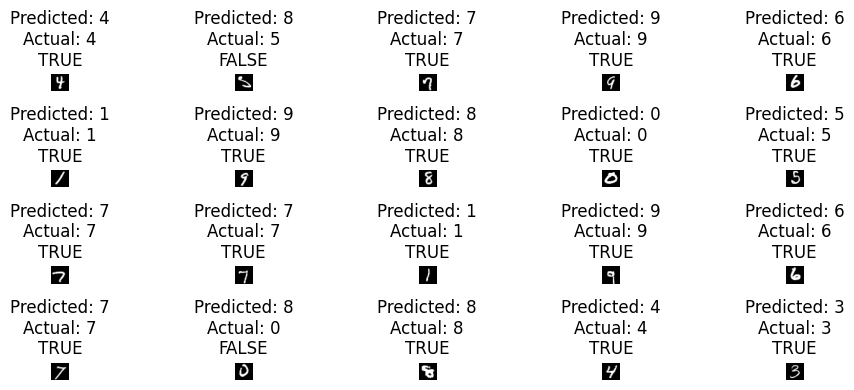

In [82]:
n = 20
cols = 5
fig, axs = plt.subplots(nrows=n//cols, ncols=cols, figsize=(10, 4))


for i in range(n):

    randInd = torch.randint(0,len(testDataset),(1,))
    image, label = testDataset[randInd.item()]

    axs[i // 5, i % 5].imshow(image.squeeze(), cmap="gray")
    axs[i // 5, i % 5].axis("off")

    model.eval()
    with torch.inference_mode():
        prediction = model(image.unsqueeze(0).to(device))


    predicted_class = torch.argmax(prediction).item()
    # print("Ground truth label:", label)
    # print(f"Predicted Digit: {predicted_class}")

    res = ""
    if label == predicted_class:
        res = "TRUE"
        # print("TRUE")
    else:
        res = "FALSE"
        # print("FALSE")
   
    axs[i // 5, i % 5].set_title(f"Predicted: {predicted_class}\nActual: {label}\n{res}")

plt.tight_layout()
plt.show()

Save Model

In [114]:
# Save Model
import os

baseName = "HDR.pth"
i = 1
fileName = baseName

while os.path.exists(fileName):
    fileName = f"{os.path.splitext(baseName)[0]}_{i}.pth"
    i += 1

torch.save(model.state_dict(), fileName)

torch.Size([1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

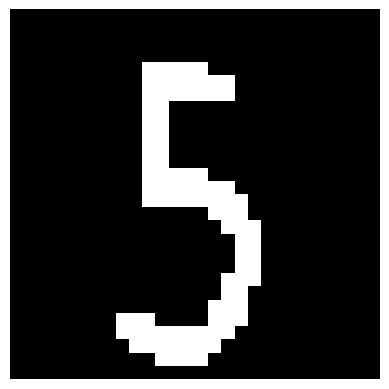

In [94]:
import base64
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import torchvision.transforms
from torchvision.transforms import Resize, ToTensor, Grayscale

x = ""
# x = x.split(",")[1]
# print(x)


x = base64.b64decode(x)
image_array = np.frombuffer(x, np.uint8)
image = plt.imread(BytesIO(image_array))

# plt.imshow(image)
# plt.axis("off")

x = ""

x = base64.b64decode(x)
image = Image.open(BytesIO(x))
desiredSize = (28,28)

# Transform
transform = transforms.Compose([
    Resize(desiredSize),
    transforms.Grayscale(),
    ToTensor(),
])
transformed_image = transform(image)


print(transformed_image.shape)

a = transformed_image.numpy()
a = a.transpose(1,2,0)
plt.imshow(a, cmap="gray")
plt.axis("off")

In [81]:
model = LeNet(1,10)
state_dict = torch.load("HDR.pth", torch.device(device))
model.load_state_dict(state_dict)
model = model.to(device)

In [93]:
# model(transformed_image.squeeze())
# torch.argmax(model(image.unsqueeze(0).to(device))).item()
torch.argmax(model(transformed_image.unsqueeze(0).to(device))).item()


5